In [1]:
# Compressed sensing demo by Brian Busemeyer.
# Python 3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
%matplotlib inline
import multiprocessing as mp
# These two libraries are available on my github https://github.com/bbusemeyer/busempyer
import plot_tools as pt
import mython as my
import compressed_sensing as cs
from imp import reload
import PIL as pyim
pt.matplotlib_header()

Sum of residues of fit: 1.43114686768e-15
L1 error: 1.92
L2 error: 0.83


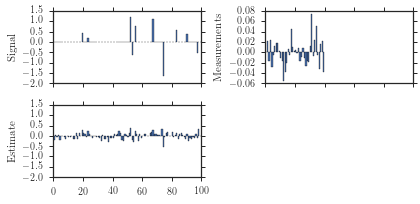

In [2]:
# Here's a naive attempt to solve the problem.
fig,ax = plt.subplots(2,2,sharex='all',sharey='col')
signal_size = 100
frac_measurements = 0.4
signal_sparsity = 0.1

num_measurements = int(round(frac_measurements * signal_size))

# Generates a random sparse signal.
reload(cs)
signal = cs.gen_rand_signal(signal_size,signal_sparsity)
ax[0,0].bar(range(len(signal)),signal)
#ax[0].set_ylim(-1.1,1.1)
ax[0,0].set_ylabel("Signal")

# The measurements are related by some change-of-basis matrix, which I take as random too.
basis_change = np.random.randn(num_measurements,signal_size)/signal_size

# This means the measurements are given by change of basis applied to signal.
measurements = np.dot(basis_change,signal)
ax[0,1].bar(range(len(measurements)),measurements)
ax[0,1].set_ylabel("Measurements")
#ax[0,1].annotate("(different basis)",
#              (0.6,0.7),xycoords='axes fraction')

estimate,res,rank,svs = np.linalg.lstsq(basis_change,measurements)
ax[1,0].bar(range(len(estimate)),estimate)
ax[1,0].set_ylabel("Estimate")

# Properties of the estimate.
print("Sum of residues of fit:",abs(np.dot(basis_change,estimate)-measurements).sum())

plt.delaxes(ax[1,1])

# Check how good we did.
l1err = np.linalg.norm(estimate-signal,1) / np.linalg.norm(signal,1)
l2err = np.linalg.norm(estimate-signal,2) / np.linalg.norm(signal,2)
print("L1 error: %.2f"%l1err)
print("L2 error: %.2f"%l2err)
#ax[1].annotate("MSE: %.2f;  MAE: %.2f"%(mse,mae),
#              (0.1,0.8),xycoords='axes fraction')
fig.set_size_inches(6,3)
fig.tight_layout()
fig.savefig("sample_l2.eps")

Optimization terminated successfully.
L1 error: 0.00
L2 error: 0.00


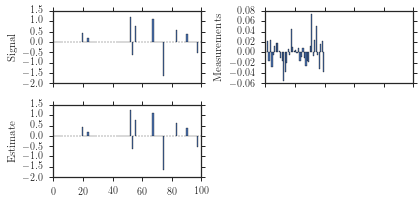

In [3]:
# Now minimize l1 norm.
reload(cs)
fig,ax = plt.subplots(2,2,sharex='all',sharey='col')
#signal_size = 100
#frac_measurements = 0.4
#signal_sparsity = 0.2

num_measurements = int(round(frac_measurements * signal_size))

# Generates a random sparse signal.
reload(cs)
#signal = cs.gen_rand_signal(signal_size,signal_sparsity)
ax[0,0].bar(range(len(signal)),signal)
#ax[0].set_ylim(-1.1,1.1)
ax[0,0].set_ylabel("Signal")

# The measurements are related by some change-of-basis matrix, which I take as random too.
#basis_change = np.random.randn(num_measurements,signal_size)/signal_size

# This means the measurements are given by change of basis applied to signal.
measurements = np.dot(basis_change,signal)
ax[0,1].bar(range(len(measurements)),measurements)
ax[0,1].set_ylabel("Measurements")
#ax[0,1].annotate("(different basis)",
#              (0.6,0.7),xycoords='axes fraction')

coefs,ineq_mat,eq_mat,eq_vec = cs.setup_linprog(basis_change,measurements)

result = sci.optimize.linprog(
    coefs,
    ineq_mat,
    np.zeros(2*signal_size),
    eq_mat,
    eq_vec,
    bounds=[(-np.inf,np.inf) for var in eq_vec],
    options={'maxiter':10000})
print(result['message'])
if result['message'] != 'Optimization terminated successfully.':
    estimate = np.nan
else:
    estimate = result['x'][:signal_size]
    ax[1,0].bar(range(len(estimate)),estimate)
    ax[1,0].set_ylabel("Estimate")

plt.delaxes(ax[1,1])

# Check how good we did.
l1err = np.linalg.norm(estimate-signal,1) / np.linalg.norm(signal,1)
l2err = np.linalg.norm(estimate-signal,2) / np.linalg.norm(signal,2)
print("L1 error: %.2f"%l1err)
print("L2 error: %.2f"%l2err)
#ax[1].annotate("MSE: %.2f;  MAE: %.2f"%(mse,mae),
#              (0.1,0.8),xycoords='axes fraction')
fig.set_size_inches(6,3)
fig.tight_layout()
fig.savefig("sample_l1.eps")

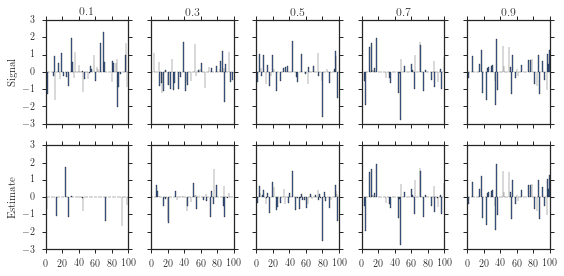

In [11]:
# Series of signal processing plots.
reload(cs)
signal_size = 100
signal_sparsity = 0.5
frac_measurements = np.arange(0.1,1.0,0.2)
fig,ax = plt.subplots(2,frac_measurements.shape[0],sharex=True,sharey=True)
pmap = dict(zip(frac_measurements,range(frac_measurements.shape[0])))
errs = []
for frac in frac_measurements:
    col = pmap[frac]
    errs.append(cs.plot_linprog(signal_size,frac,signal_sparsity,ax.T[col]))
    ax[0,col].set_title("%.1f"%frac)
ax[0,0].set_ylabel("Signal")
ax[1,0].set_ylabel("Estimate")
fig.set_size_inches(8,4)
fig.tight_layout()
fig.savefig("measure_scan.eps")

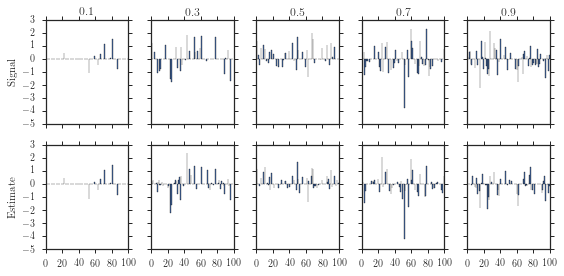

In [14]:
# Series of signal processing plots.
reload(cs)
signal_size = 100
frac_measurement = 0.5
signal_sparisties = np.arange(0.1,1.0,0.2)
fig,ax = plt.subplots(2,signal_sparisties.shape[0],sharex=True,sharey=True)
pmap = dict(zip(signal_sparisties,range(signal_sparisties.shape[0])))
errs = []
for spar in signal_sparisties:
    col = pmap[spar]
    errs.append(cs.plot_linprog(signal_size,frac_measurement,spar,ax.T[col]))
    ax[0,col].set_title("%s"%spar)
ax[0,0].set_ylabel("Signal")
ax[1,0].set_ylabel("Estimate")
fig.set_size_inches(8,4)
fig.tight_layout()
fig.savefig("sparsity_scan.eps")

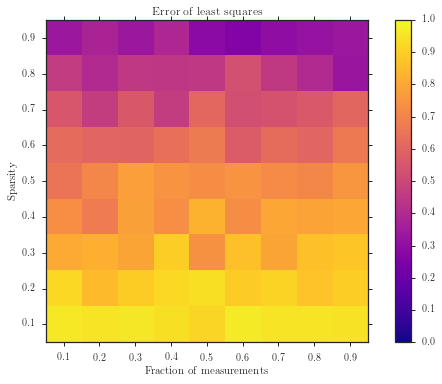

In [15]:
# Map out the parameter space. 
reload(cs)
signal_size = 100
frac_measurements = np.arange(0.1,1.0,0.1,)
signal_sparsities = np.arange(0.1,1.0,0.1)
pspace = my.cross_prod([frac_measurements,signal_sparsities])
fm_grid,sp_grid = np.meshgrid(frac_measurements,signal_sparsities)
def wrapper(args):
    return cs.test_leastsquares(signal_size,*args)
with mp.Pool(8) as pool:
    results = np.array(pool.map(wrapper, pspace))
#plt.pcolormesh(fm_grid,sp_grid,results.reshape(fm_grid.shape))
fig,ax = plt.subplots(1,1)
im = ax.imshow(results.reshape(fm_grid.shape),
               cmap='plasma',
               interpolation='nearest',
               origin='lower left',
               aspect='equal',
               vmax=1,vmin=0)
ax.set_xticks(range(frac_measurements.shape[0]))
ax.set_xticklabels(frac_measurements)
ax.set_ylabel("Sparsity")
ax.set_yticks(range(signal_sparsities.shape[0]))
ax.set_yticklabels(signal_sparsities)
ax.set_xlabel("Fraction of measurements")
ax.set_title("Error of least squares")
fig.colorbar(im)
fig.tight_layout()
fig.savefig("leastsq_pmap.eps")

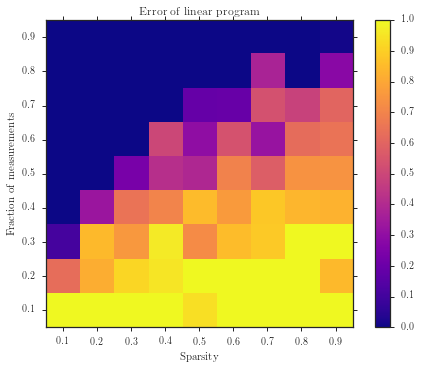

In [16]:
# Map out the parameter space. 
reload(cs)
signal_size = 100
frac_measurements = np.arange(0.1,1.0,0.1)
signal_sparsities = np.arange(0.1,1.0,0.1)
pspace = my.cross_prod([frac_measurements,signal_sparsities])
fm_grid,sp_grid = np.meshgrid(frac_measurements,signal_sparsities)
def wrapper(args):
    return cs.test_linprog(signal_size,*args)
with mp.Pool(8) as pool:
    results = np.array(pool.map(wrapper, pspace))
#plt.pcolormesh(fm_grid,sp_grid,results.reshape(fm_grid.shape))
fig,ax = plt.subplots(1,1)
im = ax.imshow(results.reshape(fm_grid.shape),
               cmap='plasma',
               interpolation='nearest',
               origin='lower left',
               aspect='equal',
               vmax=1,vmin=0)
ax.set_xticks(range(signal_sparsities.shape[0]))
ax.set_xticklabels(signal_sparsities)
ax.set_xlabel("Sparsity")    
ax.set_yticks(range(frac_measurements.shape[0]))
ax.set_yticklabels(frac_measurements)
ax.set_ylabel("Fraction of measurements")
ax.set_title("Error of linear program")
fig.colorbar(im)
fig.savefig("linear_pmap.eps")

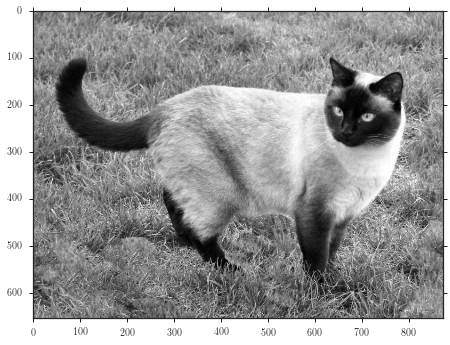

In [17]:
im = pyim.Image.open("cat.jpg").convert("L")
pmap = np.array(im,dtype=np.uint8)
plt.imshow(pmap,cmap='gray')
plt.savefig("cat_plotted.eps")

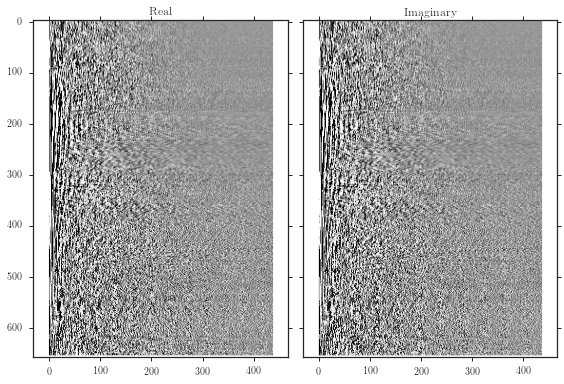

In [18]:
fmap = np.fft.rfft(pmap)
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(fmap.real[1:,1:],vmin=-1000,vmax=1000)
ax[1].imshow(fmap.real[1:,1:],vmin=-1000,vmax=1000)
ax[0].set_title("Real")
ax[1].set_title("Imaginary")
fig.tight_layout()
plt.savefig("cat_fourier.eps")

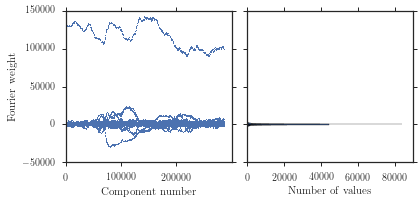

In [19]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(fmap.real.flatten(),',')
hist = ax[1].hist(fmap.real.flatten(),bins=1000,orientation='horizontal')
for a in ax:
    a.set_xticks(pt.thin_ticks(a.get_xticks()))
ax[0].set_ylabel("Fourier weight")
ax[0].set_xlabel("Component number")
ax[1].set_xlabel("Number of values")
fig.set_size_inches(6,3)
fig.tight_layout()
fig.savefig("sparseness_real.eps")

In [20]:
fmap = np.fft.rfft(pmap)
pre = (abs(fmap)>1e-8).sum()
fmap[abs(fmap) < 1000] = 0.
post = (abs(fmap)>1e-8).sum()
print("Precompression:",pre)
print("Postcompression:",post)
print("Ratio:",post/pre)

Precompression: 285798
Postcompression: 46171
Ratio: 0.161551165509


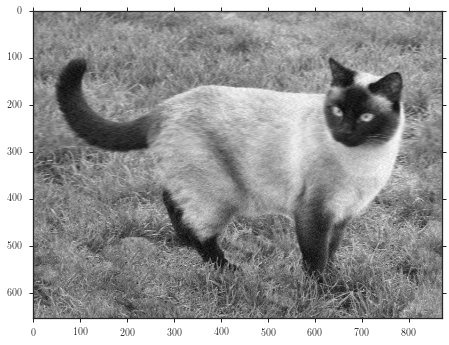

In [21]:
remap = np.fft.irfft(fmap)
plt.imshow(remap,cmap='gray')
plt.savefig("cat_plotted_compressed.eps")

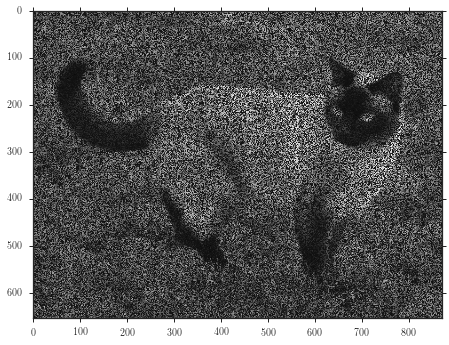

In [22]:
remap = np.fft.irfft(fmap)
total = remap.flatten().shape[0]
nset_zero = int(round(0.8*total))
xs = np.random.randint(0,remap.shape[0],nset_zero)
ys = np.random.randint(0,remap.shape[1],nset_zero)
for coord in zip(xs,ys):
    remap[coord] = 0
plt.imshow(remap,cmap='gray')
plt.savefig("cat_plotted_cut.eps")

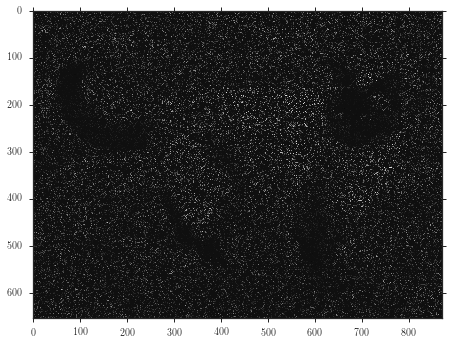

In [23]:
reload(cs)
sample = cs.sample_image(remap,0.2)
plt.imshow(sample,cmap="gray")

In [24]:
im.thumbnail((60,60))
smap = np.array(im)
fshape = smap.flatten().shape[0]
sshape = smap.shape
ssamp = cs.sample_image(smap,0.4)

In [25]:
fourier = np.zeros((fshape,fshape),dtype=complex)
one_part = np.zeros(fshape,dtype=complex)
for i in range(fshape):
    one_part[i] = 1.
    fourier[:,i] = np.fft.fft(one_part.reshape(smap.shape)).flatten()
    one_part[i] = 0.

In [26]:
mat_trans = np.dot(fourier,smap.flatten()).reshape(sshape)
func_trans = np.fft.fft(smap)
print("Is the transformation consistent?",np.allclose(func_trans,mat_trans))

Is the transformation consistent? True


In [27]:
reorder = (-ssamp.flatten()).argsort()

In [28]:
ressamp = ssamp.flatten()[reorder][:int(round(fshape*0.4))]
refourier = fourier[reorder][:int(round(fshape*0.4))]

In [29]:
reload(cs)
coefs,ineq_mat,eq_mat,eq_vec = cs.setup_linprog(refourier.real,ressamp)

In [30]:
# This runs forever. My algorithm can't handle this. 
# Plus should change this to a real basis. Haar basis is one option.
reload(sci)
result = sci.optimize.linprog(
    coefs,
    ineq_mat,
    np.zeros(2*fshape),
    eq_mat,
    eq_vec,
    bounds=[(-np.inf,np.inf) for var in eq_vec],
    options={'maxiter':10000})

KeyboardInterrupt: 